In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('..'))


from log_processing import process_log, from_csv

In [57]:
def calculate_vwaps(data):
    b1 = data["bid_price_1"]
    b1v = data["bid_volume_1"]
    b2 = data["bid_price_2"]
    b2v = data["bid_volume_2"]
    b3 = data["bid_price_3"]
    b3v = data["bid_volume_3"]
    a1 = data["ask_price_1"]
    a1v = data["ask_volume_1"]
    a2 = data["ask_price_2"]
    a2v = data["ask_volume_2"]
    a3 = data["ask_price_3"]
    a3v = data["ask_volume_3"]

    bid_vwap = (b1 * b1v + b2 * b2v + b3 * b3v) / (b1v + b2v + b3v)
    ask_vwap = (a1 * a1v + a2 * a2v + a3 * a3v) / (a1v + a2v + a3v)
    vwap = (bid_vwap + ask_vwap) / 2
    return bid_vwap, ask_vwap, vwap

In [58]:
round = 2

DAY_2 = 2
DAY_1 = 1
DAY_0 = 0
days = [DAY_2, DAY_1, DAY_0]

products = ["CROISSANTS", "JAMS", "DJEMBES", "PICNIC_BASKET1", "PICNIC_BASKET2"]
day_data = {}

for day in days:
    activities, trades = from_csv(round, day, "../../data")
    product_data = {}
    for product in products:
        product_data[product] = activities[activities["product"] == product].reset_index()

        product_data[product]["spread"] = product_data[product]["ask_price_1"] - product_data[product]["bid_price_1"]
        bid_vwap, ask_vwap, vwap = calculate_vwaps(product_data[product])
        product_data[product]["bid_vwap"] = bid_vwap
        product_data[product]["ask_vwap"] = ask_vwap
        product_data[product]["vwap"] = vwap

    day_data[day] = product_data


for day in days:
    synthetic_pb1_mid = 6 * day_data[day]["CROISSANTS"]["mid_price"] + 3 * day_data[day]["JAMS"]["mid_price"] + day_data[day]["DJEMBES"]["mid_price"]
    synthetic_pb1_ask = 6 * day_data[day]["CROISSANTS"]["ask_price_1"] + 3 * day_data[day]["JAMS"]["ask_price_1"] + day_data[day]["DJEMBES"]["ask_price_1"]
    synthetic_pb1_bid = 6 * day_data[day]["CROISSANTS"]["bid_price_1"] + 3 * day_data[day]["JAMS"]["bid_price_1"] + day_data[day]["DJEMBES"]["bid_price_1"]
    synthetic_pb1_vask = 6 * day_data[day]["CROISSANTS"]["ask_vwap"] + 3 * day_data[day]["JAMS"]["ask_vwap"] + day_data[day]["DJEMBES"]["ask_vwap"]
    synthetic_pb1_vbid = 6 * day_data[day]["CROISSANTS"]["bid_vwap"] + 3 * day_data[day]["JAMS"]["bid_vwap"] + day_data[day]["DJEMBES"]["bid_vwap"]
    synthetic_pb1_vwap = 6 * day_data[day]["CROISSANTS"]["vwap"] + 3 * day_data[day]["JAMS"]["vwap"] + day_data[day]["DJEMBES"]["vwap"]
    synthetic_pb1 = pd.DataFrame({
        "timestamp": day_data[day]["CROISSANTS"]["timestamp"],
        "mid_price": synthetic_pb1_mid,
        "ask_price_1": synthetic_pb1_ask,
        "bid_price_1": synthetic_pb1_bid,
        "ask_vwap": synthetic_pb1_vask,
        "bid_vwap": synthetic_pb1_vbid,
        "vwap": synthetic_pb1_vwap
    })
    synthetic_pb2_mid = 4 * day_data[day]["CROISSANTS"]["mid_price"] + 2 * day_data[day]["JAMS"]["mid_price"]
    synthetic_pb2_ask = 4 * day_data[day]["CROISSANTS"]["ask_price_1"] + 2 * day_data[day]["JAMS"]["ask_price_1"]
    synthetic_pb2_bid = 4 * day_data[day]["CROISSANTS"]["bid_price_1"] + 2 * day_data[day]["JAMS"]["bid_price_1"]
    synthetic_pb2_vask = 4 * day_data[day]["CROISSANTS"]["ask_vwap"] + 2 * day_data[day]["JAMS"]["ask_vwap"]
    synthetic_pb2_vbid = 4 * day_data[day]["CROISSANTS"]["bid_vwap"] + 2 * day_data[day]["JAMS"]["bid_vwap"]
    synthetic_pb2_vwap = 4 * day_data[day]["CROISSANTS"]["vwap"] + 2 * day_data[day]["JAMS"]["vwap"]
    synthetic_pb2 = pd.DataFrame({
        "timestamp": day_data[day]["CROISSANTS"]["timestamp"],
        "mid_price": synthetic_pb2_mid,
        "ask_price_1": synthetic_pb2_ask,
        "bid_price_1": synthetic_pb2_bid,
        "ask_vwap": synthetic_pb2_vask,
        "bid_vwap": synthetic_pb2_vbid,
        "vwap": synthetic_pb2_vwap
    })

    day_data[day]["SYN_PICNIC_BASKET1"] = synthetic_pb1
    day_data[day]["SYN_PICNIC_BASKET2"] = synthetic_pb2

In [59]:
combined_data = {}
for day in days:
    for product in day_data[day].keys():
        product_data = day_data[day][product]
        if product not in combined_data.keys():
            combined_data[product] = [product_data]
        else:
            product_data["timestamp"] += combined_data[product][-1]["timestamp"].max() + 100
            combined_data[product].append(product_data)

for product in combined_data.keys():
    combined_data[product] = pd.concat(combined_data[product], ignore_index=True).reset_index()

In [67]:
# Analyze each day separately or combine them
# data = day_data[DAY_0]
data = combined_data
time = data["CROISSANTS"]["timestamp"]

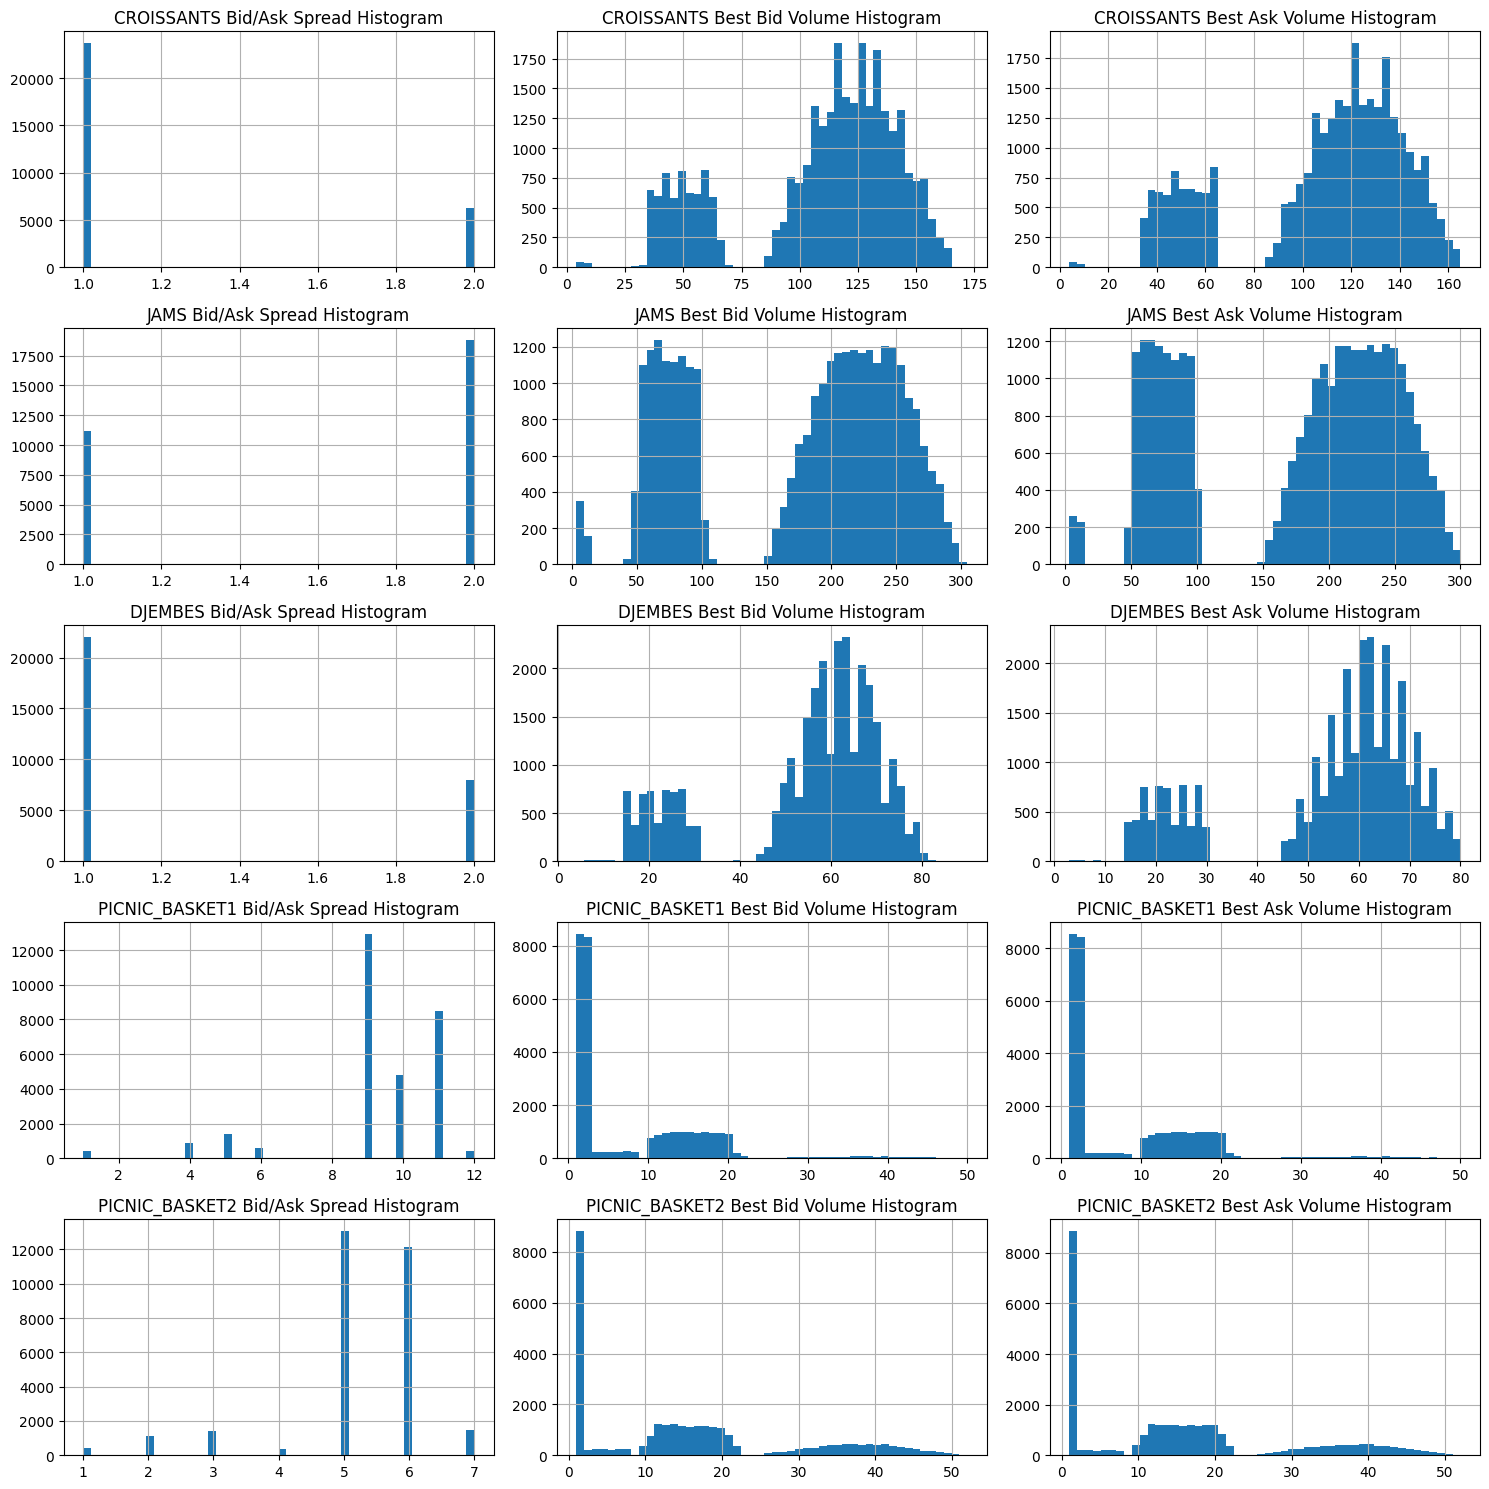

In [68]:
fig, axs = plt.subplots(len(products), 3, figsize=(15, 15))
for i, product in enumerate(products):
    for j in range(3):
        if j == 0:
            axs[i, j].hist(data[product]["spread"], bins=50)
            axs[i, j].set_title(f"{product} Bid/Ask Spread Histogram")
            axs[i, j].grid()
        elif j == 1:
            axs[i, j].hist(data[product]["bid_volume_1"], bins=50)
            axs[i, j].set_title(f"{product} Best Bid Volume Histogram")
            axs[i, j].grid()
        else:
            axs[i, j].hist(data[product]["ask_volume_1"], bins=50)
            axs[i, j].set_title(f"{product} Best Ask Volume Histogram")
            axs[i, j].grid()

plt.tight_layout()
# plt.savefig("figures/new_products_price_histograms.png")

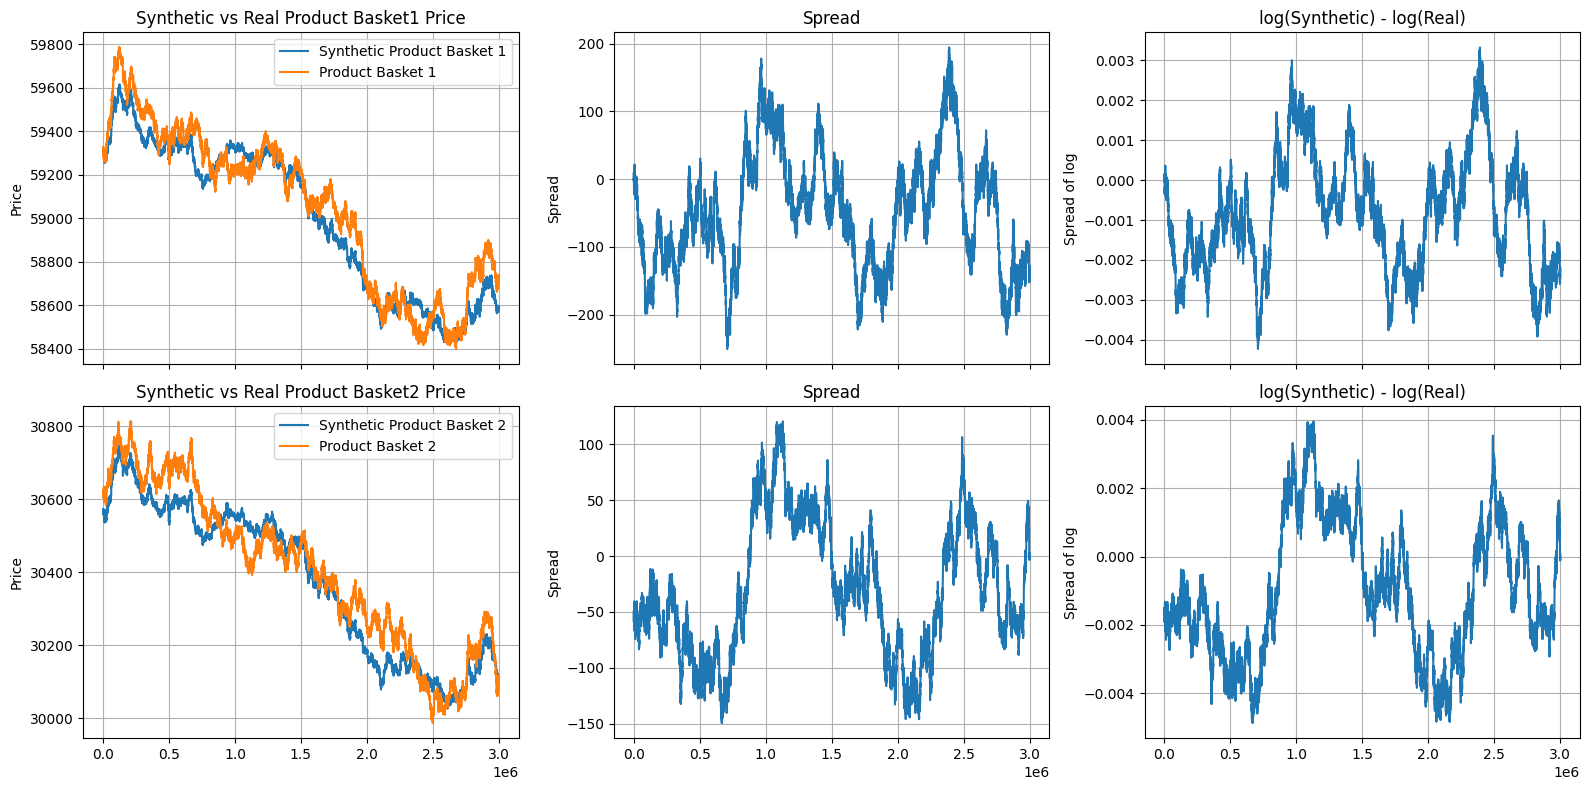

In [69]:
fig, axs = plt.subplots(2, 3, figsize=(16, 8), sharex=True)

for i in range(2):
    axs[i, 0].plot(time, data[f"SYN_PICNIC_BASKET{i+1}"]["mid_price"], label=f"Synthetic Product Basket {i+1}")
    axs[i, 0].plot(time, data[f"PICNIC_BASKET{i+1}"]["mid_price"], label=f"Product Basket {i+1}")
    axs[i, 0].grid()
    axs[i, 0].legend()
    axs[i, 0].set_ylabel("Price")
    axs[i, 0].set_title(f"Synthetic vs Real Product Basket{i+1} Price")

    spread = data[f"SYN_PICNIC_BASKET{i+1}"]["mid_price"] - data[f"PICNIC_BASKET{i+1}"]["mid_price"]
    axs[i, 1].plot(time, spread, label="Spread")
    axs[i, 1].grid()
    axs[i, 1].set_ylabel("Spread")
    axs[i, 1].set_title("Spread")

    ratio = np.log(data[f"SYN_PICNIC_BASKET{i+1}"]["mid_price"]) - np.log(data[f"PICNIC_BASKET{i+1}"]["mid_price"])
    axs[i, 2].plot(time, ratio)
    axs[i, 2].grid()
    axs[i, 2].set_ylabel("Spread of log")
    axs[i, 2].set_title("log(Synthetic) - log(Real)")

plt.tight_layout()
# plt.savefig("figures/synthetic_vs_real.png")

In [70]:
from scipy import stats
from statsmodels.tsa.stattools import adfuller

def interpret_adf(result):
    p_val = result[1]

    print(f"p-value: {p_val:.4f}")
    
    # Interpretation
    if p_val < 0.05:
        print("Result: Series is STATIONARY ")
       
    else:
        print("Result: Series is NON-STATIONARY")

print("Correlation between synthetic and real Product Basket 1")
corr, p_value = stats.pearsonr(data["SYN_PICNIC_BASKET1"]["mid_price"], data["PICNIC_BASKET1"]["mid_price"])
print(f"Pearson correlation coefficient: {corr}")
print(f"P-value: {p_value}")
print("Synthetic PB1 returns:")
syn_pb1_returns = np.diff(data["SYN_PICNIC_BASKET1"]["mid_price"]) / data["SYN_PICNIC_BASKET1"]["mid_price"][:-1]
interpret_adf(adfuller(syn_pb1_returns))
pb1_returns = np.diff(data["PICNIC_BASKET1"]["mid_price"]) / data["PICNIC_BASKET1"]["mid_price"][:-1]
print("PB1 returns:")
interpret_adf(adfuller(pb1_returns))

print()

print("Correlation between synthetic and real Product Basket 2")
corr, p_value = stats.pearsonr(data["SYN_PICNIC_BASKET2"]["mid_price"], data["PICNIC_BASKET2"]["mid_price"])
print(f"Pearson correlation coefficient: {corr}")
print(f"P-value: {p_value}")
print("Synthetic PB2 returns:")
syn_pb2_returns = np.diff(data["SYN_PICNIC_BASKET2"]["mid_price"]) / data["SYN_PICNIC_BASKET2"]["mid_price"][:-1]
interpret_adf(adfuller(syn_pb2_returns))
pb2_returns = np.diff(data["PICNIC_BASKET2"]["mid_price"]) / data["PICNIC_BASKET2"]["mid_price"][:-1]
print("PB2 returns:")
interpret_adf(adfuller(pb2_returns))

Correlation between synthetic and real Product Basket 1
Pearson correlation coefficient: 0.9722889725256896
P-value: 0.0
Synthetic PB1 returns:
p-value: 0.0000
Result: Series is STATIONARY 
PB1 returns:
p-value: 0.0000
Result: Series is STATIONARY 

Correlation between synthetic and real Product Basket 2
Pearson correlation coefficient: 0.9604927615024059
P-value: 0.0
Synthetic PB2 returns:
p-value: 0.0000
Result: Series is STATIONARY 
PB2 returns:
p-value: 0.0000
Result: Series is STATIONARY 


In [71]:
y1 = data["SYN_PICNIC_BASKET1"]["mid_price"]
y2 = data["PICNIC_BASKET1"]["mid_price"]
spread = y1 - y2
print("Spread between synthetic and real Product Basket 1")
interpret_adf(adfuller(spread))

print()
y1 = np.log(data["SYN_PICNIC_BASKET1"]["mid_price"])
y2 = np.log(data["PICNIC_BASKET1"]["mid_price"])
spread = y1 - y2
print("Ratio between synthetic and real Product Basket 1")
interpret_adf(adfuller(spread))

Spread between synthetic and real Product Basket 1
p-value: 0.0212
Result: Series is STATIONARY 

Ratio between synthetic and real Product Basket 1
p-value: 0.0213
Result: Series is STATIONARY 


In [72]:
pb1_bid = data["PICNIC_BASKET1"]["bid_price_1"]
pb1_ask = data["PICNIC_BASKET1"]["ask_price_1"]

cro_bid = data["CROISSANTS"]["bid_price_1"]
cro_ask = data["CROISSANTS"]["ask_price_1"]

jams_bid = data["JAMS"]["bid_price_1"]
jams_ask = data["JAMS"]["ask_price_1"]

dje_bid = data["DJEMBES"]["bid_price_1"]
dje_ask = data["DJEMBES"]["ask_price_1"]

spread_buy = pb1_ask - (6 * cro_bid + 3 * jams_bid + dje_bid)
spread_sell = pb1_bid - (6 * cro_ask + 3 * jams_ask + dje_ask)

z_score_buy = (spread_buy - np.mean(spread_buy)) / np.std(spread_buy)
z_score_sell = (spread_sell - np.mean(spread_sell)) / np.std(spread_sell)

open_buy_threshold = -1.5
close_buy_threshold = -0.5
open_sell_threshold = 1.5
close_sell_threshold = 0.5

In [73]:
print(f"Buy Spread mean: {spread_buy.mean()}")
print(f"Buy Spread std: {spread_buy.var()}")
print(f"Sell Spread mean: {spread_sell.mean()}")    
print(f"Sell Spread std: {spread_sell.var()}")

Buy Spread mean: 60.08306666666667
Buy Spread std: 7246.505116766114
Sell Spread mean: 37.4418
Sell Spread std: 7250.250221100704


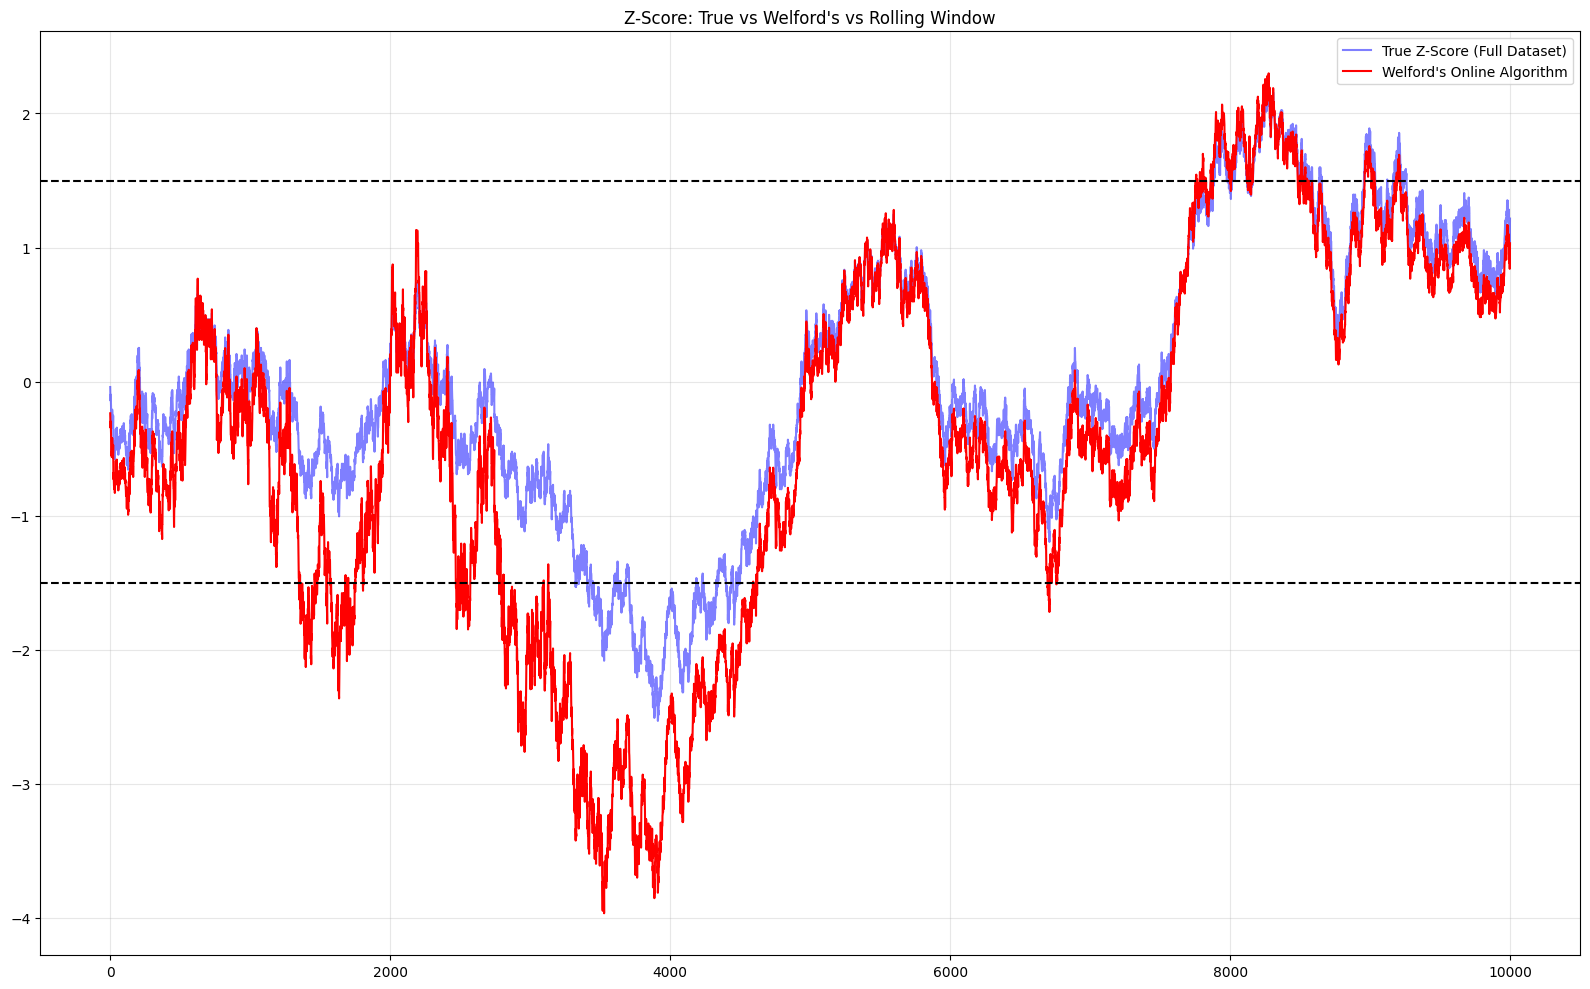

Number of signals (z-score >= 1.5):
True Z-Score: 1749
Welford Z-Score: 2941


In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Calculate spreads
spread_buy = pb1_ask - (6 * cro_bid + 3 * jams_bid + dje_bid)

# True Z-Score (using full dataset)
true_mean = np.mean(spread_buy)
true_std = np.std(spread_buy)
true_z_score = (spread_buy - true_mean) / true_std

# 1. Welford's Online Algorithm
class WelfordStatsWithPriors:
    def __init__(self, initial_mean=None, initial_variance=None, initial_count=10):
        self.n = initial_count if initial_mean is not None else 0
        self.mean = initial_mean if initial_mean is not None else 0.0
        self.M2 = initial_variance * initial_count if initial_variance is not None else 0.0
        
    def update(self, x):
        self.n += 1
        delta = x - self.mean
        self.mean += delta / self.n
        delta2 = x - self.mean
        self.M2 += delta * delta2
        
    def get_mean(self):
        return self.mean
    
    def get_std(self):
        return np.sqrt(self.M2 / self.n if self.n > 1 else 1.0)


# Initialize our statistics calculators
N = 300
BUY_MEAN = 60.08
BUY_VAR = 7246.50

welford_stats = WelfordStatsWithPriors(BUY_MEAN, BUY_VAR, N)


# Calculate z-scores for each method
welford_z_scores = []
ewma_fast_z_scores = []
ewma_slow_z_scores = []
rolling_z_scores = []


# Process the data
for i, spread in enumerate(spread_buy):
    # Update statistics
    welford_stats.update(spread)
    
    # Calculate z-scores
    if welford_stats.n > 10:  # Ensure some minimum data points
        welford_z = (spread - BUY_MEAN) / welford_stats.get_std()
        welford_z_scores.append(welford_z)
    else:
        welford_z_scores.append(np.nan)


# Create dataframe for plotting
df = pd.DataFrame({
    'spread': spread_buy,
    'true_z_score': true_z_score,
    'welford_z_score': welford_z_scores,
})

# Plot the results
fig, axes = plt.subplots(1, 1, figsize=(16, 10))

# Plot 2: True Z-Score vs Welford
axes.plot(df['true_z_score'], label='True Z-Score (Full Dataset)', color='blue', alpha=0.5)
axes.plot(df['welford_z_score'], label="Welford's Online Algorithm", color='red')
axes.axhline(y=1.5, color='black', linestyle='--')
axes.axhline(y=-1.5, color='black', linestyle='--')
axes.set_title("Z-Score: True vs Welford's vs Rolling Window")
axes.legend()
axes.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

# Print some statistics about signal generation
signals_true = (abs(df['true_z_score']) >= 1.5).sum()
signals_welford = (abs(df['welford_z_score']) >= 1.5).sum()

print("Number of signals (z-score >= 1.5):")
print(f"True Z-Score: {signals_true}")
print(f"Welford Z-Score: {signals_welford}")